## Simulation of production-degradation process using Spatiocyte, egfrd, ODE, and spatial RDME algorithm.

solver  ode


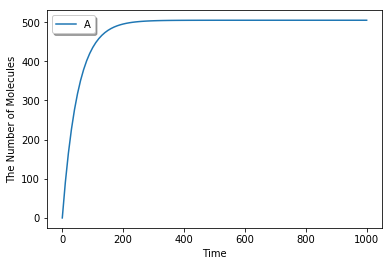

In [1]:
from ecell4 import *
from ecell4.extra import ensemble
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

duration = 1000

nproc=350
L=cbrt(100) #length of cubic box
Ca=5. #initial concentration of A molecule
Cb=1. #initial concentration of B molecule
k0= 0.1 #production rate

#simulate singlerun of reaction 0->A, A+B->B, output is number of molecules
def singlerun(rm,D,solver='ode',intrinsic=False):   
    print('solver ',solver)
    V = L**3 
    Nb=int(Cb*V)
    M = max(int(min(cbrt(Nb), L / (2 * rm))), 3)        
    rv=rm
    if solver=='spa':
        rv=rm*1.0208582
        solver=("spatiocyte",rv)
        V=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),rm*1.0208582)    
    elif solver=='meso':
        K = int(L/2/rm)
        solver = ("meso",Integer3(K,K,K))
    elif solver=='egfrd':
        solver=('egfrd', Integer3(M, M, M))    
    keff = k0/Ca/Cb   #degradation rate
    kd = 4*np.pi*rm*2*D*2
    ka = keff*kd/(kd-keff)  #bimolecular intrinsic rate
    assert(ka>0)
    #reaction model:
    with species_attributes():
        A | {'D': D, 'radius':rv  }
        B | {'D': D, 'radius':rv  }

    with reaction_rules():
        ~A > A | k0
        A + B >B | (ka if intrinsic else keff)
    m = get_model()
    obs=run_simulation(duration,model=m,y0={'B':Nb},return_type='observer',species_list=['A'],solver=solver,volume=ones()*L)
    data = np.array(obs.data()).T
    #print('mean [A]',np.mean(data[1][50:])/V)   
    return obs

#singlerun(molecule/voxel size, diffusion coefficient, solver,intrinsic rate?)
obs=singlerun(0.005,0.1,'ode',False)
#obs=singlerun(0.005,0.1,'spa',True)
#obs=singlerun(0.02,0.1,'spa',True)
#obs=singlerun(0.05,0.1,'spa',True)
#obs=singlerun(0.05,0.01,'spa',True)
#obs=singlerun(0.05,0.02,'spa',True)
#obs=singlerun(0.005,0.1,'egfrd',True)
#obs=singlerun(0.02,0.1,'egfrd',True)
#obs=singlerun(0.05,0.1,'egfrd',True)
#obs=singlerun(0.05,0.01,'egfrd',True)
#obs=singlerun(0.05,0.02,'egfrd',True)
#obs=singlerun(0.05,0.1,'meso',False)
#obs=singlerun(1,0.1,'meso',False)
viz.plot_number_observer(obs) #divide by actual volume to get concentration

### load and plot time series of [A] from data used in paper

spatiocyte, l=0.01, D=0.1, mean concentration=5.0572
spatiocyte, l=0.04, D=0.1, mean concentration=4.9837
spatiocyte, l=0.1, D=0.1, mean concentration=4.9901
egfrd, l=0.01, D=0.1, mean concentration=4.9677
egfrd, l=0.04, D=0.1, mean concentration=4.9751
egfrd, l=0.1, D=0.1, mean concentration=4.9502


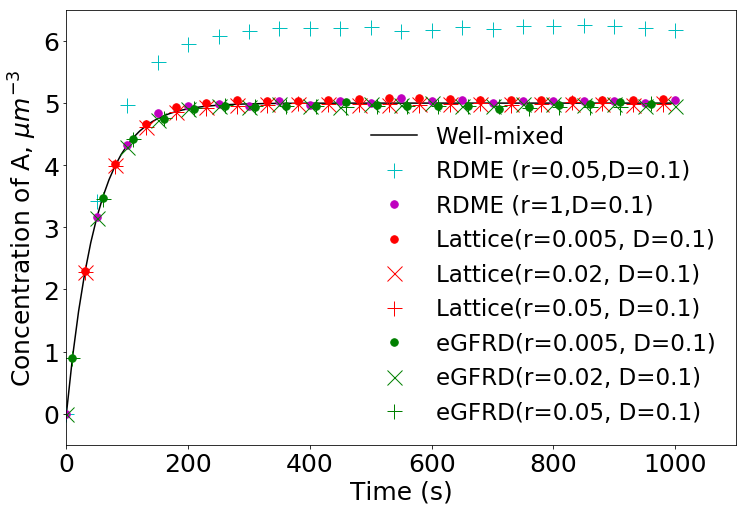

In [2]:
import numpy as np
import matplotlib.pylab as plt
from ecell4 import *
%matplotlib inline

fig,ax=plt.subplots(1,1,figsize=(12,8))
fs=25
lw=3
ms=15
lg=5
L=cbrt(100)#length of cubic box
V=L**3

#loading ODE model result
ode=np.genfromtxt('data/pd_ode_rm0.05',delimiter=',')
ax.plot(ode[:,0],ode[:,1],'k-',label='Well-mixed',markersize=ms)

#loading RDME simulation result
meso = np.genfromtxt('data/pd_meso_rm0.05_D0.1_L4.64',delimiter=',')
ax.plot(meso[:,0][::lg],meso[:,1][::lg]/V,'c+',label='RDME (r=0.05,D=0.1)',markersize=ms)
meso = np.genfromtxt('data/pd_meso_rm1.0_D0.1_L4.64',delimiter=',')
ax.plot(meso[:,0][::lg],meso[:,1][::lg]/V,'m.',label='RDME (r=1,D=0.1)',markersize=ms)

#loading Spatiocyte simulation result
for y in [[0.005,0.1,'r.'],[0.02,0.1,'rx'],[0.05,0.1,'r+']]:
    fac=1.0208582
    Vac=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),y[0]*fac) #actual volume in lattice compartment 
    d=np.genfromtxt('data/pd_spa_rm{}_D{}_L4.64b'.format(y[0],y[1]),delimiter=',')
    mean=np.mean(d[:,1][50:])/Vac
    print('spatiocyte, l={}, D={}, mean concentration={:.5}'.format(2*y[0],y[1],mean))
    ax.plot(d[:,0][3::lg],d[:,1][3::lg]/Vac,y[2],label='Lattice(r={}, D={})'.format(y[0],y[1]),markersize=ms)

#loading egfrd simulation result
for y in [[0.005,0.1,'g.'],[0.02,0.1,'gx'],[0.05,0.1,'g+']]:
    d=np.genfromtxt('data/pd_egfrd_rm{}_D{}_L4.64'.format(y[0],y[1]),delimiter=',',skip_header=1)
    mean=np.mean(d[:,1][50:])/V
    print('egfrd, l={}, D={}, mean concentration={:.5}'.format(2*y[0],y[1],mean))
    ax.plot(d[:,0][::lg],d[:,1][::lg]/V,y[2],label='eGFRD(r={}, D={})'.format(y[0],y[1]),markersize=ms)

ax.set_xlim(0,1100)
ax.set_ylim(-0.5,6.5)
ax.tick_params(labelsize=fs)
ax.set_xlabel('Time (s)',fontsize=fs)
ax.set_ylabel('Concentration of A, $\mu m^{-3}$',fontsize=fs)
plt.legend(loc='best',fontsize=fs-2,frameon=False)


### plot equilibrium mean [A] vs diffusion coefficient

Lattice,rm=0.05,D=0.1,con=4.990135427399938
Lattice,rm=0.05,D=0.02,con=4.848828080559129
Lattice,rm=0.05,D=0.01,con=4.585748500941207
egfrd,rm=0.05,D=0.1,con=4.950238000000002
egfrd,rm=0.05,D=0.02,con=4.8023
egfrd,rm=0.05,D=0.01,con=4.526736000000001
rdme,rm=1.0,D=0.1,con=5.020990711861533
rdme,rm=1.0,D=0.01,con=5.149795665147106
rdme,rm=1.0,D=0.02,con=5.071642709175896


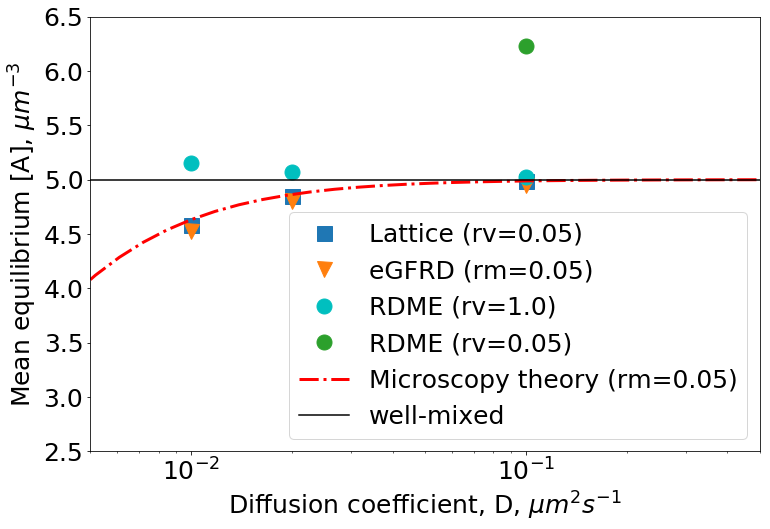

In [3]:
from math import pi as pi
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from ecell4 import *

fac=1.0208582
ms=15
lw=3
fs=25
fig,ax1=plt.subplots(1,1,figsize=(12,8))

def getconcb(rm,D,L,sim): #load time series data
    V=L**3
    if (sim=='spa'):    
        V=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),fac*rm)  
        d=np.genfromtxt('data/pd_{}_rm{}_D{}_L{}b'.format(sim,rm,D,L),delimiter=',')    
    else:
        d=np.genfromtxt('data/pd_{}_rm{}_D{}_L{}'.format(sim,rm,D,L),delimiter=',')    
    return np.mean(d[:,1][90:])/V

def mtheory(rm,Ds,m): #microscopic theory
    def cal(rm,D):
        R=rm*2
        Ca=5
        Cb=1  #[B]
        k0=0.1  #production rate
        keff = k0/Ca/Cb #degradation rate     
        kd=4*pi*R*D*2    
        ka=keff*kd/(kd-keff)
        kon=kd*ka/(kd+ka)
        t2=(4*pi*Cb*(ka*R/(ka+kd))**3)**0.5
        return 0.1/kon/(1+t2)    
    conas = [cal(rm,D) for D in Ds]
    plt.plot(Ds,conas,m,label='Microscopy theory (rm={:.3})'.format(rm),linewidth=lw)

meane = [[4.9502380000000024, 0.05, 0.1],[4.8023, 0.05, 0.02],[4.5267360000000014,0.05,0.01] ]
meanspab=[[0.05,0.1,4.64],[0.05,0.02,4.64],[0.05,0.01,4.64]]
meanmeso=[[1.,0.1,4.64],[1.,0.01,4.64],[1.,0.02,4.64]]

cons=[]
#load spatiocyte data
for rm,D,L in meanspab:
    con=getconcb(rm,D,L,'spa')
    cons.append(con)
    print('Lattice,rm={},D={},con={}'.format(rm,D,con))
ax1.plot(np.asarray(meanspab)[:,1],cons,'s',markersize=ms,label='Lattice (rv={})'.format(rm)) 

#load egfrd data
for con,rm,D in meane:
    print('egfrd,rm={},D={},con={}'.format(rm,D,con))
ax1.plot(np.asarray(meane)[:,2],np.asarray(meane)[:,0],'v',markersize=ms,label='eGFRD (rm={})'.format(rm)) 

conm=[]
#load spatial rdme data
for rm,D,L in meanmeso:
    con=getconcb(rm,D,L,'meso')
    conm.append(con)
    print('rdme,rm={},D={},con={}'.format(rm,D,con))   
ax1.plot(np.asarray(meanmeso)[:,1],conm,'co',markersize=ms,label='RDME (rv={})'.format(rm))      
con=getconcb(0.05,0.1,4.64,'meso')
ax1.plot(0.1,con,'o',markersize=ms,label='RDME (rv={})'.format(0.05))      

#plot microscopy theory
mtheory(0.05,np.logspace(-2.5,1,50),'r-.')

ax1.plot(np.linspace(0.005,0.5,100),[5]*100,'k-',label='well-mixed')
ax1.set_xscale('log')
ax1.set_xlabel('Diffusion coefficient, D, $\mu m^{2} s^{-1}$',fontsize=fs)
ax1.set_ylabel('Mean equilibrium [A], $\mu m^{-3}$',fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.set_ylim(2.5,6.5)
ax1.set_xlim(0.005,0.5)
ax1.legend(loc=4,fontsize=fs)